In [1]:
from dask.array.image import imread as imr
import os
import tifffile
import napari
import numpy as np
import matplotlib.pyplot as plt
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
from runBigfishDetection import saveSpotsNPZ, reorderZstack
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from copy import deepcopy
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ

In [2]:
# pip install numpy==1.23.0

In [3]:
homeFolder = '/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/'
nameKey = 'Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F'
# homeFolder = '/home/rachel/single/spinningSequence/'
# nameKey = 'hela_K11_ON-_F'
imsQ = '11'
pathToTimeFrames = homeFolder+nameKey+imsQ+'/*.tif'
cellNumber = '1'
path_input = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
nucleiStackForm = nameKey+imsQ+"_cell_"
pathToTimeFramesCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'
stackCell = imr(pathToTimeFramesCell)
maxImageCell = np.max(stackCell, axis=1)
MaxTimePoint = stackCell.shape[0]
path_input

'/media/rachel/9d56c1ff-e031-4e35-9f3c-fcd7d3e80033/Analysis/20230720/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_10ng.ml_tnf_exp1_4_F11/cell_1/'

In [4]:
viewer = napari.Viewer()
viewer.add_image(
        maxImageCell, colormap='green' #maxImageCell
        )

<Image layer 'maxImageCell' at 0x7f1a2c62a6a0>

In [5]:
maxProjSavePath = homeFolder+nameKey+imsQ+'/'
with tifffile.TiffWriter(maxProjSavePath+'MAX_cell'+cellNumber+'.tif', imagej=True) as tif:
    tif.save(maxImageCell)

/tmp/ipykernel_117748/288345892.py:3: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(maxImageCell)


In [6]:
selectedThreshold = 1415


In [7]:
voxelRadius = (600, 121, 121)
objectRadius = (600, 103, 103)

spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=voxelRadius, 
    object_radius_nm=objectRadius, 
    ndim=3)
    
rna_list = []
spots_list=[]
for t in range(0,MaxTimePoint,10):

    path = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna_all = stack.read_image(path)
    rna = reorderZstack(rna_all,4)
    #rna = rna[:11]
    rna_mip = stack.maximum_projection(rna)
    rna_list.append(rna)

images=rna_list
n=len(images)
print("Total number of images : "+str(n))


Total number of images : 90


In [8]:
for rna in images:
    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
    spots_list.append(spots_)


image list found!
Found 950
Found 950 spots, max intensity = 4184


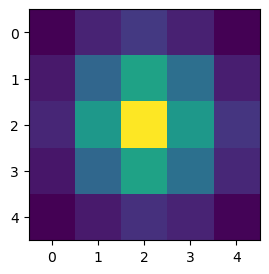

In [9]:
reference_spot = buildReferenceSpotFromImages(images, spots_list, alpha=0.5, gamma=5, voxelSize=voxelRadius, objectSize=objectRadius)
%matplotlib inline
plt.figure(num=3,figsize=(3,3))
plt.imshow(np.max(reference_spot, axis=0))
refSpot = deepcopy(reference_spot)

In [10]:
spotsFrame, clustersFrames, ThresholdFrames = getSpotAndClusters(path_input, 
                                                                 reference_spot, 
                                                                 cellnumber=cellNumber, 
                                                                 startTime=0,
                                                                 stopTime=MaxTimePoint, 
                                                                 thresholdManual=selectedThreshold, 
                                                                 beta=1.5, 
                                                                 gamma=5,
                                                                 numberOfSpots=2,
                                                                 radiusCluster=600, 
                                                                 voxelSize=voxelRadius, 
                                                                 objectSize=objectRadius,
                                                                 extensionMov='.tif')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323

/home/rachel/anaconda3/envs/napari_env/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870


In [13]:
def saveSpotsNPZ(spotsFrame, clustersFrames, ThresholdFrames, cellName, pathTocellCrops, reference_spot):
    outfileName = os.path.join(pathTocellCrops,str(cellName)+'_spots_and_clusters')
    np.savez(outfileName, 
             spotsFrame=spotsFrame, 
             clustersFrames=clustersFrames,
             ThresholdFrames=ThresholdFrames,
             reference_spot=reference_spot, allow_pickle=True) 

In [14]:
pathTocellCrops = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
saveSpotsNPZ(np.array(spotsFrame, dtype=object), 
             np.array(clustersFrames, dtype=object), 
             np.array(ThresholdFrames, dtype=object), 
             cellNumber, 
             pathTocellCrops, 
             reference_spot)

In [12]:
spcl = np.load(pathTocellCrops+str(cellNumber)+'_spots_and_clusters.npz',allow_pickle=True)

spotsFrame = spcl['spotsFrame']
clustersFrames = spcl['clustersFrames']
ThresholdFrames = spcl['ThresholdFrames']

In [26]:
stackCell = imr(pathToTimeFramesCell)
print(stackCell.shape)
maxImageCell = np.max(stackCell, axis=1)

(900, 13, 189, 189)


In [12]:
def getDetectedPointsForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-1])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:]
    return pts_coords

def getDetectedClustersForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-3])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:3]
    return pts_coords

def set_pts_features(pts_layer, cls_layer, pts_coordinates, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    cls_layer.edge_color_cycle = ['red']
#     cls_layer.edge_color_mode = 'cycle'
    cls_layer.edge_color='red'
    
    pts_layer.edge_color='white'
    pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrame(cluster_coordinate,frameNumber)
    cls_layer.selected_data = set()
    pts_layer.selected_data = set()


pts_coordinates = spotsFrame
cluster_coordinate = clustersFrames
viewer = napari.Viewer()
image_layer = viewer.add_image(
        maxImageCell, colormap='green' #maxImageCell
        )
if image_layer.data.ndim == 4:
    bigfishSpots = spotsFrame
elif image_layer.data.ndim == 3:
    bigfishSpots = getDetectedPointsForFrame(pts_coordinates,int(np.shape(maxImageCell)[0]/2))
    
bigfish_Spots = viewer.add_points(
        getDetectedPointsForFrame(pts_coordinates,int(np.shape(maxImageCell)[0]/2)),
        face_color='#00000000',
        size=4,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots'
        )

bigfish_clusters = viewer.add_points(
        getDetectedClustersForFrame(cluster_coordinate,int(np.shape(maxImageCell)[0]/2)),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        symbol='diamond',
        name = 'bigFish Clusters'
        )

# bigfish_TxSite = viewer.add_labels(Tx_label_clean, name='Tx Site',opacity=0.3)  bigfish_TxSite

viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_Spots, bigfish_clusters, pts_coordinates, cluster_coordinate, event.value)
        )

<function __main__.<lambda>(event)>